# #TEXT CLASSIFICATION ON YOUTUBE DATA

# importing libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
# Import Data
data = pd.read_csv('C:\\Users\\91981\\Desktop\\Video_Classification_Dataset.csv')
data = data.iloc[:, 1:]     # Remove extra un-named column
data.head(5)

,Video Id,Title,Description,Category
0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel
3,-LzdIILq5vE,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...,travel
4,7ByoBJYXU0k,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M...",travel


# Data preprocessing and cleaning

In [3]:
# Missing Values
num_missing_desc = data.isnull().sum()[2]    # No. of values with msising descriptions
print('Number of missing values: ' + str(num_missing_desc))
data = data.dropna()

Number of missing values: 334


In [4]:
# Change to lowercase
data['Title'] = data['Title'].map(lambda x: x.lower())
data['Description'] = data['Description'].map(lambda x: x.lower())

# Remove numbers
data['Title'] = data['Title'].map(lambda x: re.sub(r'\d+', '', x))
data['Description'] = data['Description'].map(lambda x: re.sub(r'\d+', '', x))

# Remove Punctuation
data['Title']  = data['Title'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
data['Description']  = data['Description'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove white spaces
data['Title'] = data['Title'].map(lambda x: x.strip())
data['Description'] = data['Description'].map(lambda x: x.strip())

# Tokenize into words
data['Title'] = data['Title'].map(lambda x: word_tokenize(x))
data['Description'] = data['Description'].map(lambda x: word_tokenize(x))
 
# Remove non alphabetic tokens
data['Title'] = data['Title'].map(lambda x: [word for word in x if word.isalpha()])
data['Description'] = data['Description'].map(lambda x: [word for word in x if word.isalpha()])
# filter out stop words
stop_words = set(stopwords.words('english'))
data['Title'] = data['Title'].map(lambda x: [w for w in x if not w in stop_words])
data['Description'] = data['Description'].map(lambda x: [w for w in x if not w in stop_words])

# Word Lemmatization
lem = WordNetLemmatizer()
data['Title'] = data['Title'].map(lambda x: [lem.lemmatize(word,"v") for word in x])
data['Description'] = data['Description'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

# Turn lists back to string
data['Title'] = data['Title'].map(lambda x: ' '.join(x))
data['Description'] = data['Description'].map(lambda x: ' '.join(x))


data.head(5)

,Video Id,Title,Description,Category
0,ehmsJLZlCZ0,ep travel north east india arunachal journey b...,journey arunachal north east india begin train...,travel
1,e2NQE41J5eM,travel much earn money,subscribe httpsgoogldetsmj mountaintrekker gim...,travel
2,i9E_Blai8vk,travel vlog welcome bali priscilla lee,chance fly bali whole family thanksgiving firs...,travel
3,-LzdIILq5vE,goa travel diary four days goa travel outfit i...,hope enjoy goa travel diary video dont forget ...,travel
4,7ByoBJYXU0k,step become travel blogger,travel blogger nikki vargas pin map project vo...,travel


## Label encoding classes

In [5]:
# Encode classes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data.Category)
data.Category = le.transform(data.Category)
data.head(5)

,Video Id,Title,Description,Category
0,ehmsJLZlCZ0,ep travel north east india arunachal journey b...,journey arunachal north east india begin train...,5
1,e2NQE41J5eM,travel much earn money,subscribe httpsgoogldetsmj mountaintrekker gim...,5
2,i9E_Blai8vk,travel vlog welcome bali priscilla lee,chance fly bali whole family thanksgiving firs...,5
3,-LzdIILq5vE,goa travel diary four days goa travel outfit i...,hope enjoy goa travel diary video dont forget ...,5
4,7ByoBJYXU0k,step become travel blogger,travel blogger nikki vargas pin map project vo...,5


# Vectorizing text features using TF-IDF

In [6]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_title = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidf_desc = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
labels = data.Category
features_title = tfidf_title.fit_transform(data.Title).toarray()
features_description = tfidf_desc.fit_transform(data.Description).toarray()
print('Title Features Shape: ' + str(features_title.shape))
print('Description Features Shape: ' + str(features_description.shape))

Title Features Shape: (9999, 2637)
Description Features Shape: (9999, 4858)


<AxesSubplot:title={'center':'Number of samples for each class'}>

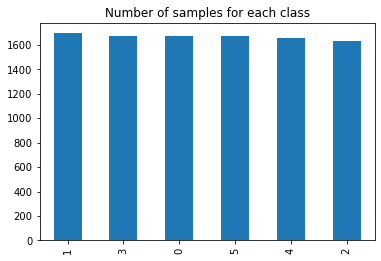

In [7]:
# Plotting class distribution
data['Category'].value_counts().sort_values(ascending=False).plot(kind='bar', y='Number of Samples', 
                                                                title='Number of samples for each class')

In [8]:
# Best 5 keywords for each class using Title Feaures
from sklearn.feature_selection import chi2
import numpy as np
N = 5
for current_class in list(le.classes_):
    current_class_id = le.transform([current_class])[0]
    features_chi2 = chi2(features_title, labels == current_class_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_title.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(current_class))
    print("Most correlated unigrams:")
    print('-' *30)
    print('. {}'.format('\n. '.join(unigrams[-N:])))
    print("Most correlated bigrams:")
    print('-' *30)
    print('. {}'.format('\n. '.join(bigrams[-N:])))
    print("\n")

# 'art and music':
Most correlated unigrams:
------------------------------
. paint
. official
. music
. art
. theatre
Most correlated bigrams:
------------------------------
. capitol theatre
. musical theatre
. work theatre
. official music
. music video


# 'food':
Most correlated unigrams:
------------------------------
. foods
. eat
. snack
. cook
. food
Most correlated bigrams:
------------------------------
. healthy snack
. snack amp
. taste test
. kid try
. street food


# 'history':
Most correlated unigrams:
------------------------------
. discoveries
. archaeological
. archaeology
. history
. anthropology
Most correlated bigrams:
------------------------------
. history channel
. rap battle
. epic rap
. battle history
. archaeological discoveries


# 'manufacturing':
Most correlated unigrams:
------------------------------
. business
. printer
. process
. print
. manufacture
Most correlated bigrams:
------------------------------
. manufacture plant
. lean manufacture
. add

In [9]:
# Best 5 keywords for each class using Description Features
from sklearn.feature_selection import chi2
import numpy as np
N = 5
for current_class in list(le.classes_):
    current_class_id = le.transform([current_class])[0]
    features_chi2 = chi2(features_description, labels == current_class_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_desc.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(current_class))
    print("Most correlated unigrams:")
    print('-' *30)
    print('. {}'.format('\n. '.join(unigrams[-N:])))
    print("Most correlated bigrams:")
    print('-' *30)
    print('. {}'.format('\n. '.join(bigrams[-N:])))
    print("\n")

# 'art and music':
Most correlated unigrams:
------------------------------
. official
. paint
. music
. art
. theatre
Most correlated bigrams:
------------------------------
. capitol theatre
. click listen
. production connexion
. official music
. music video


# 'food':
Most correlated unigrams:
------------------------------
. foods
. eat
. snack
. cook
. food
Most correlated bigrams:
------------------------------
. special offer
. hiho special
. come play
. sponsor series
. street food


# 'history':
Most correlated unigrams:
------------------------------
. discoveries
. archaeological
. history
. archaeology
. anthropology
Most correlated bigrams:
------------------------------
. episode epic
. epic rap
. battle history
. rap battle
. archaeological discoveries


# 'manufacturing':
Most correlated unigrams:
------------------------------
. factory
. printer
. process
. print
. manufacture
Most correlated bigrams:
------------------------------
. process make
. lean manufacture


# Modeling and Training

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:3], data['Category'], random_state = 0)
X_train_title_features = tfidf_title.transform(X_train['Title']).toarray()
X_train_desc_features = tfidf_desc.transform(X_train['Description']).toarray()
features = np.concatenate([X_train_title_features, X_train_desc_features], axis=1)


X_train.head()






,Title,Description
3072,lec mit introduction computer science program ...,lecture goals course computation introduction ...
713,travel cargo ship philippines,travel cargo ship yes something many people th...
3598,store cat food vs homemade,patreon httpswwwpatreoncomjunskitchen thank wa...
1680,indian tourism travel goa hd,create video youtube video editor httpwwwyoutu...
819,travel hong kong,heres hong kong vlog stay overnight airport vi...


In [12]:
y_train.head()

3072    4
713     5
3598    1
1680    5
819     5
Name: Category, dtype: int32

In [14]:
# Naive Bayes
nb = MultinomialNB().fit(features, y_train)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.naive_bayes import MultinomialNB
from keras.utils.np_utils import to_categorical

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100

# Combining titles and descriptions into a single sentence
titles = data['Title'].values
descriptions = data['Description'].values
data_for_lstms = []
for i in range(len(titles)):
    temp_list = [titles[i], descriptions[i]]
    data_for_lstms.append(' '.join(temp_list))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_for_lstms)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X = tokenizer.texts_to_sequences(data_for_lstms)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

# One-hot Encode labels
Y = pd.get_dummies(data['Category']).values
print('Shape of label tensor:', Y.shape)

# Splitting into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)

Found 26134 unique tokens.
Shape of data tensor: (9999, 50)
Shape of label tensor: (9999, 6)


# Performance Evaluation

                        precision    recall  f1-score   support

         art and music       0.92      0.95      0.94       415
                  food       0.97      0.95      0.96       449
               history       0.97      0.95      0.96       418
         manufacturing       0.95      0.99      0.97       398
science and technology       0.95      0.94      0.94       414
                travel       0.97      0.95      0.96       406

              accuracy                           0.96      2500
             macro avg       0.96      0.96      0.96      2500
          weighted avg       0.96      0.96      0.96      2500



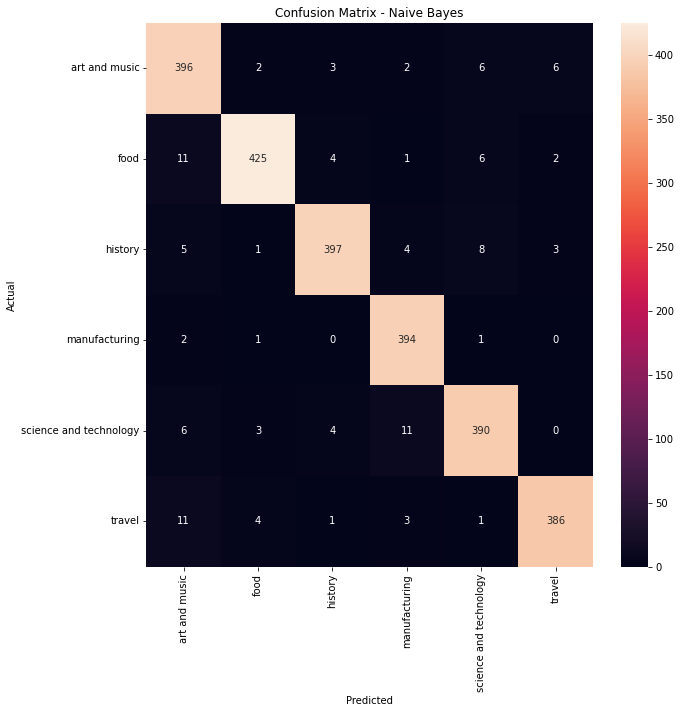

C:\Users\91981\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


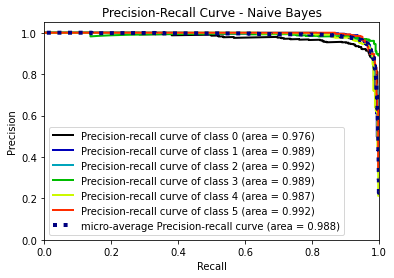

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:3], data['Category'], random_state = 0)
X_test_title_features = tfidf_title.transform(X_test['Title']).toarray()
X_test_desc_features = tfidf_desc.transform(X_test['Description']).toarray()
test_features = np.concatenate([X_test_title_features, X_test_desc_features], axis=1)



#Naive Bayes
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

X_test_title_features = tfidf_title.transform(X_test['Title']).toarray()
X_test_desc_features = tfidf_desc.transform(X_test['Description']).toarray()
test_features = np.concatenate([X_test_title_features, X_test_desc_features], axis=1)

# Naive Bayes
y_pred = nb.predict(test_features)
y_probas = nb.predict_proba(test_features)

print(metrics.classification_report(y_test, y_pred, target_names=list(le.classes_)))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

skplt.metrics.plot_precision_recall_curve(y_test, y_probas)
plt.title('Precision-Recall Curve - Naive Bayes')
plt.show()